### Pose Keypoint Head Demo

In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
import torch
from tqdm import tqdm

import sys
sys.path.append("../")
from readout_pose import train_pose
from readout_training import train_helpers
from readout_pose import annotate_pose

/opt/conda/envs/readout/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


**Load the Diffusion Extractor and Readout Head**

The demo is pre-loaded to the SDv1-5 pose keypoint readout head.

In [2]:
device = "cuda"
config = OmegaConf.load("configs/annotate_pose.yaml")
batch_size = config["batch_size"]
size = (config["res"], config["res"])
_, diffusion_extractor, aggregation_network = train_helpers.load_models(ckpt_path=config["aggregation_ckpt"])
aggregation_network = aggregation_network.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: generation
idxs: None
output_resolution: 64
prompt: 
negative_prompt: 
save_mode: hidden
Using output head with 18 channels


**Estimate the Pose with the Readout Head**

Set the paths to the images you would like to estimate the pose of! If you would like to run the readout head on a large set of images, try adjusting the input folder `read_root` in `annotate_pose.yaml` and running `annotate_pose.py`.

In [10]:
paths = [
    "data/raw/MSCOCO/images/val2017/000000023126.jpg", 
    "data/raw/MSCOCO/images/val2017/000000485027.jpg",
    "data/raw/MSCOCO/images/val2017/000000375493.jpg", 
    "data/raw/MSCOCO/images/val2017/000000352760.jpg",
    "data/raw/MSCOCO/images/val2017/000000273760.jpg",
]

  0%|          | 0/1 [00:00<?, ?it/s]

../dhf/aggregation_network.py:219: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


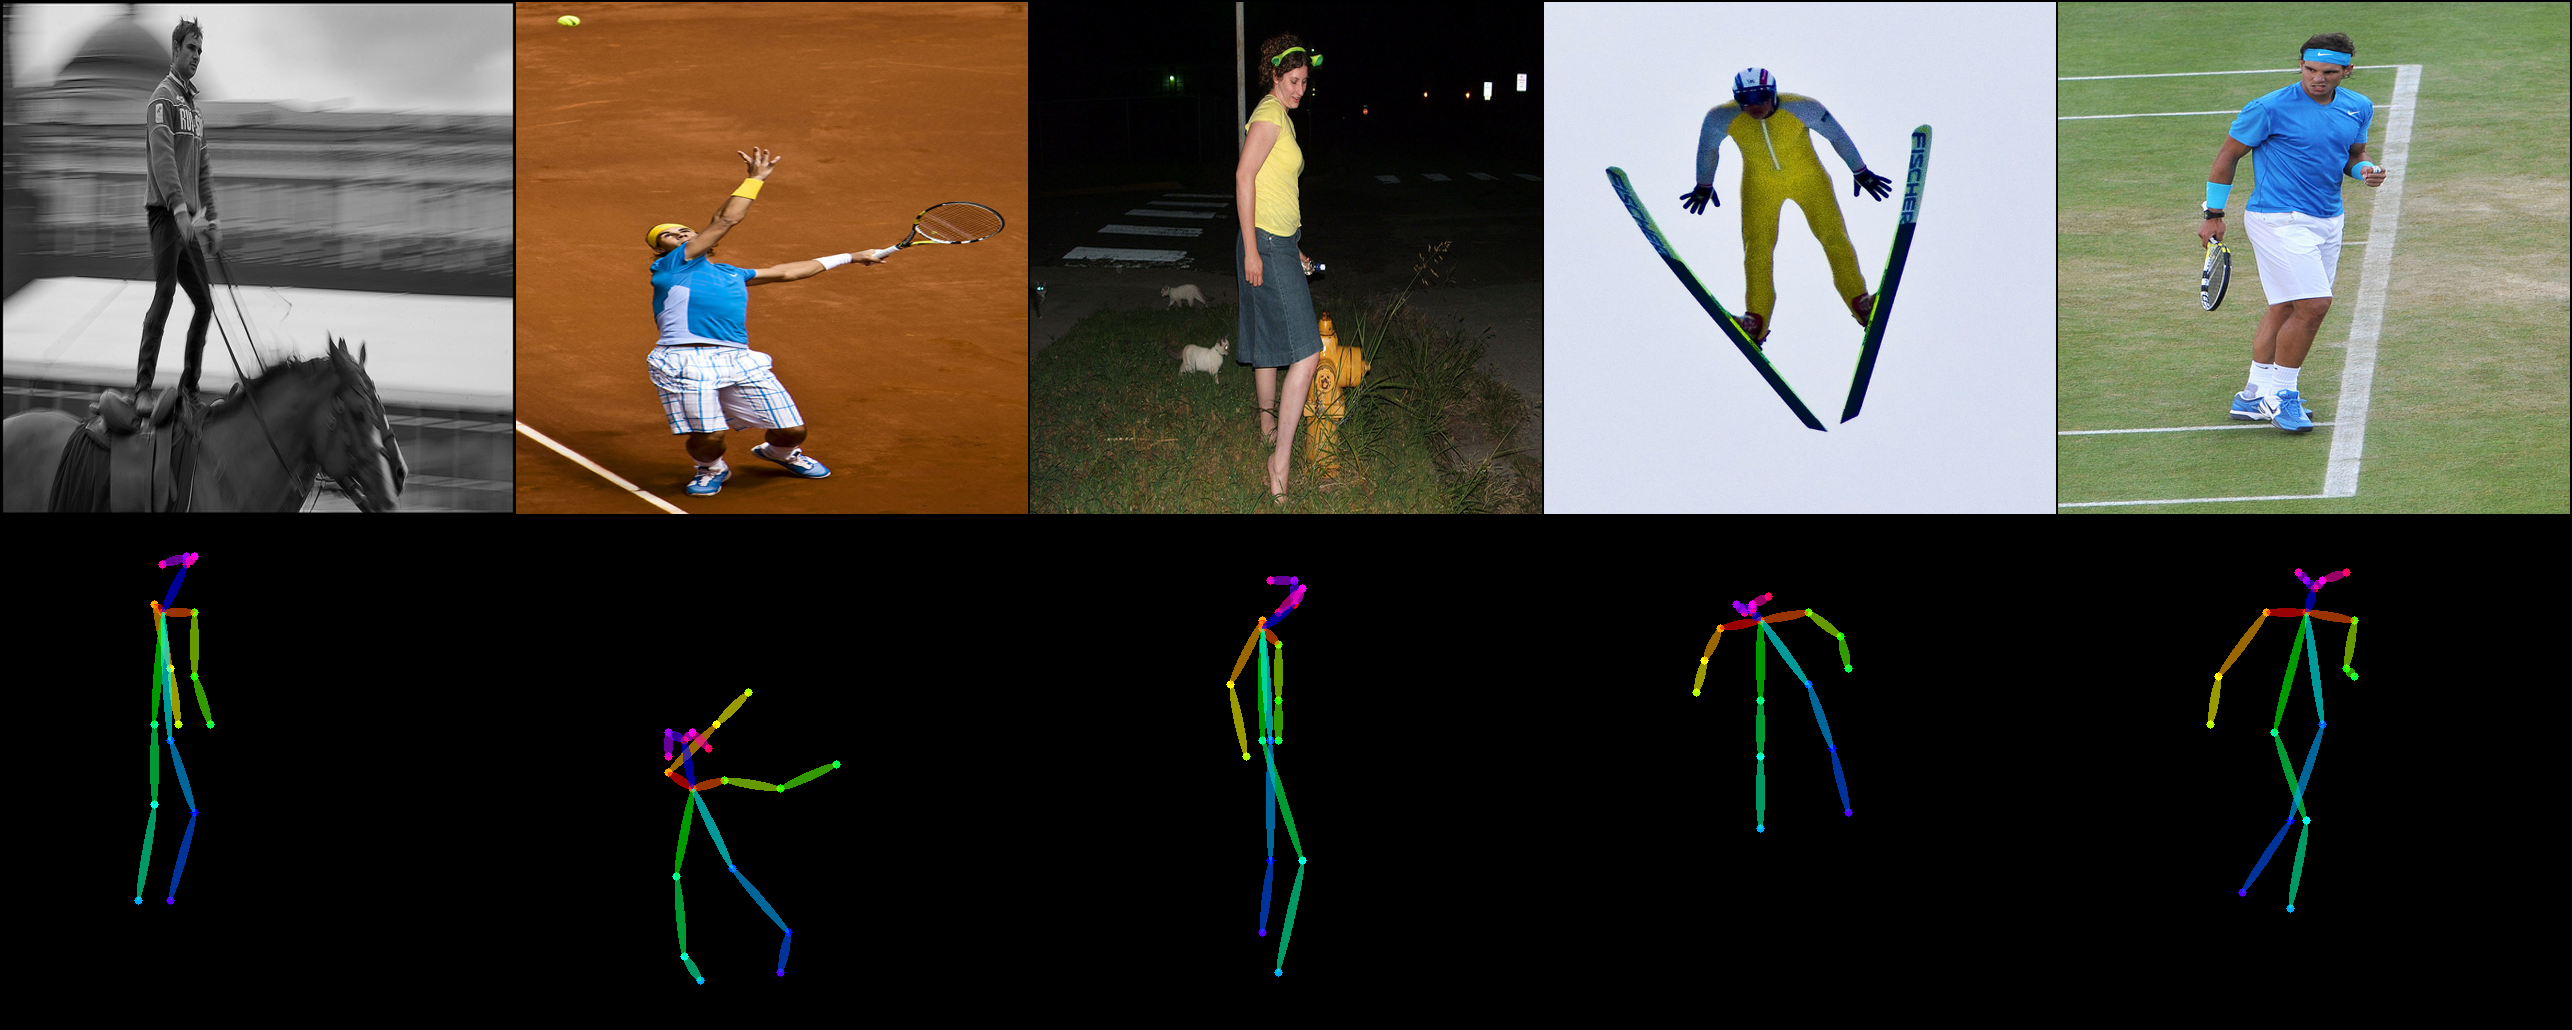

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


In [11]:
for i in tqdm(range(0, len(paths), batch_size)):
    batch_paths = paths[i:i+batch_size]
    batch = annotate_pose.create_batch(batch_paths, size, device)
    with torch.no_grad():
        imgs = batch["source"]
        pred = train_helpers.get_hyperfeats(diffusion_extractor, aggregation_network, imgs, eval_mode=True)
        pred_meta = train_pose.heatmap_to_meta(imgs, pred)
    control = train_pose.draw_meta(imgs, pred_meta)
    grid = train_helpers.log_grid(imgs=imgs, pred=control, control_range=(0, 255))
    display(grid)